# Cyber Security Threat Detection Using Machine Learning Frameworks

In [1]:
import os
os.chdir('/Users/ganeshprasad/Downloads/ML_PROJECT_CS584')
filename = 'output_final.csv'

In [2]:
#Importing packages
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Lambda, Input, Dense
from keras.losses import binary_crossentropy

from pandas.plotting import scatter_matrix

from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()  # Remove this line to enable eager execution

import warnings
warnings.filterwarnings('ignore')

from __future__ import print_function

In [3]:
# Create DataFrame
train = pd.read_csv(filename)
train_data = train.copy()
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Columns: 152 entries, 0 to 0.113
dtypes: float64(4), int64(148)
memory usage: 1.2 MB


# Data Preparation

In [4]:
array = train_data.values
X_train = array[:, 0:151]
y_train = array[:, 151]

In [5]:
# Split into a train and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=3)
print(X_train.shape)

(799, 151)


In [6]:
#Checking train and validation sets still splits across the target evenly
print(y_train.sum())
print(y_valid.sum())

9.0
2.0


### Normalise Data

In [7]:
norm_scaler = MinMaxScaler(feature_range=(0, 1), clip=True).fit(X_train)
n_X_train = norm_scaler.transform(X_train)
print(n_X_train.shape)

(799, 151)


In [8]:
n_X_valid = norm_scaler.transform(X_valid)
print(n_X_valid.shape)

(200, 151)


# Variational Autoencoder

In [9]:
#Variational Autoencoder is used to generate 20 additional features to add to the data set
class Sampling(keras.layers.Layer):
    def call(self, input_data):
        mean, log_var = input_data
        return keras.backend.random_normal(tf.shape(log_var)) * keras.backend.exp(log_var / 2) + mean

input_size = 151
code_size = 20

input_data = Input(shape=(input_size,))
hidden_1 = Dense(75, activation='relu')(input_data)
hidden_2 = Dense(35, activation='relu')(hidden_1)

code_mean = Dense(code_size)(hidden_2)
code_log_var = Dense(code_size)(hidden_2)
code = Sampling()([code_mean, code_log_var])

var_encoder = Model(input_data, outputs=code)

decoder_inputs = Input(shape=[code_size])
hidden_3 = Dense(35, activation='relu')(decoder_inputs)
hidden_4 = Dense(75, activation='relu')(hidden_3)
output_data = Dense(input_size, activation='sigmoid')(hidden_4)

var_decoder = Model(inputs=decoder_inputs, outputs=output_data)

code_input = Input(shape=(code_size,))
reconst = var_decoder(code_input)
var_ae = Model(inputs=code_input, outputs=reconst)

In [10]:
# Custom loss function for Variational Autoencoder
def losses_func(input_data, reconst):
    code_mean = var_encoder(input_data)
    code_log_var = var_encoder(input_data)
    latent_loss = -0.5 * tf.reduce_sum(1 + code_log_var - tf.exp(code_log_var) - tf.square(code_mean), axis=-1)
    reconstruction_loss = tf.keras.losses.binary_crossentropy(input_data, reconst)
    return (tf.reduce_mean(latent_loss) / 151.) + reconstruction_loss

var_ae.compile(optimizer='adam', loss=losses_func)

# Enabling eager execution
tf.config.run_functions_eagerly(True)

# Encode input data using the encoder model
encoded_train_data = var_encoder.predict(n_X_train)
encoded_valid_data = var_encoder.predict(n_X_valid)

# Train the Variational Autoencoder with the encoded features
history = var_ae.fit(x=encoded_train_data, y=n_X_train, epochs=10, validation_data=(encoded_valid_data, n_X_valid))

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7703 - val_loss: 0.5770
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.4971 - val_loss: 0.3168
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2928 - val_loss: 0.2603
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2503 - val_loss: 0.2499
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2465 - val_loss: 0.2435
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2439 - val_loss: 0.2450
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2357 - val_loss: 0.2407
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2418 - val_loss: 0.2440
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2390 - val_loss: 0.2372
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2388 - val_loss: 0.2420


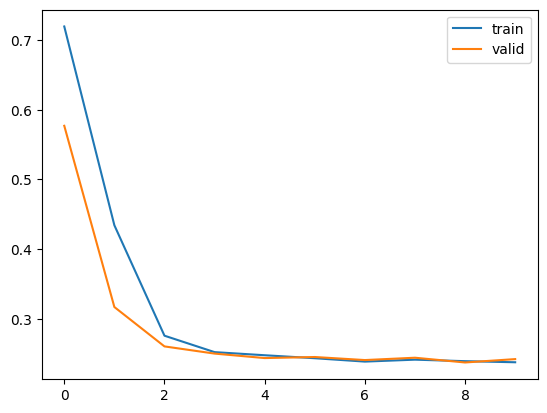

In [11]:
pyplot.plot(history.history['loss'],label = 'train')
pyplot.plot(history.history['val_loss'], label = 'valid')
pyplot.legend()
pyplot.show()  

In [12]:
#The trained variational encoder contains the reduced features from the code layer
encoded = var_encoder
gen_feat = encoded.predict(n_X_train)
print(gen_feat.shape)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
(799, 20)


In [13]:
#Statistics of the generated output features
gen_featdf = pd.DataFrame(gen_feat)
gen_featdf.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000
mean,0.196249,0.176597,-0.066571,-0.029401,-0.056493,0.057881,0.333042,-0.275570,0.237192,0.058805,-0.073271,0.252008,-0.094418,0.156024,0.083200,0.091414,-0.251215,0.140683,-0.101385,-0.008986
std,1.127500,0.910040,1.094223,1.008315,1.070804,0.998270,1.135371,1.088233,1.035587,1.086822,1.040095,1.080988,0.885895,0.993757,1.001287,1.004833,1.033001,0.971582,0.978158,1.091663
min,-3.260778,-2.782940,-3.870107,-3.148880,-3.836467,-2.765162,-3.562202,-3.820635,-3.214219,-3.416041,-3.574818,-3.620314,-3.211592,-2.951766,-3.276100,-2.883308,-3.397503,-3.150150,-3.189270,-3.260858
25%,-0.633498,-0.442013,-0.778989,-0.659108,-0.786810,-0.638533,-0.473269,-1.005812,-0.490152,-0.713915,-0.750953,-0.482602,-0.712533,-0.510530,-0.590630,-0.562304,-0.920234,-0.493064,-0.762831,-0.755161
50%,0.200975,0.204611,-0.039043,-0.006457,-0.045268,0.068204,0.370899,-0.307582,0.212057,0.121256,-0.075470,0.189184,-0.100081,0.167657,0.059217,0.120977,-0.224990,0.181239,-0.124709,0.009867
75%,0.926064,0.796880,0.670224,0.670717,0.708873,0.731391,1.163445,0.415757,1.026580,0.773789,0.632584,0.976860,0.523084,0.825009,0.714810,0.792569,0.440397,0.802850,0.552881,0.706385
max,4.617165,3.528754,4.150082,3.358701,2.693748,3.203411,3.545286,4.031078,3.126876,3.591542,3.026739,3.269275,3.510114,3.168393,3.435226,3.525137,3.153147,3.034080,3.159332,3.156031


The Variational Encoder code layer, the generated features have a mean of 0 and a standard deviation of 1

In [14]:
#Normalising the generated features and creating a dataframe with new column labels
norm_scaler20 = MinMaxScaler(feature_range = (0,1), clip = True).fit(gen_feat)
n_gen_feat = norm_scaler20.transform(gen_feat)
n_gen_feat = pd.DataFrame(n_gen_feat)
new_col_headers = map(str,[160,161,162,163,164,165,166,167,168,169, 170,171,172,173,174,175,176,177,178,179])
n_gen_feat.columns= new_col_headers

In [15]:
#Adding generated features dataframe to original features dataframe
num_data = open('column_names.csv') #Column names
num_lst = []
for label in num_data:
    label = label.rstrip()
    num_lst.append(label)

n_orig_feat = pd.DataFrame(n_X_train, columns = num_lst)
n_all_feat = pd.concat([n_orig_feat,n_gen_feat],axis = 1)
print(n_all_feat.shape)

(799, 171)


# Feature Selection

### Variance Threshold Filter

In [16]:
feat_sel = VarianceThreshold()
feat_sel.fit_transform(n_all_feat)
red_feat = pd.DataFrame(feat_sel.transform(n_all_feat))
col_lst = n_all_feat.columns[feat_sel.get_support()]
print(col_lst)
print(len(col_lst))

Index(['frame.time_delta', 'frame.time_delta_displayed', 'frame.len',
       'frame.cap_len', 'frame.marked', 'frame.ignored',
       'radiotap.flags.preamble', 'radiotap.channel.type.turbo',
       'radiotap.channel.type.2ghz', 'radiotap.channel.type.5ghz',
       'radiotap.rxflags.badplcp', 'wlan.fc.ds', 'wlan.fc.frag',
       'wlan.fc.moredata', 'wlan.fc.protected', 'wlan.fc.order',
       'wlan.duration', 'wlan.ta', 'wlan.ba.control.multitid',
       'wlan_mgt.fixed.capabilities.privacy',
       'wlan_mgt.fixed.capabilities.agility',
       'wlan_mgt.fixed.capabilities.spec_man',
       'wlan_mgt.fixed.capabilities.dsss_ofdm', 'wlan_mgt.fixed.reason_code',
       'wlan_mgt.ds.current_channel', 'wlan_mgt.tim.dtim_count',
       'wlan_mgt.tim.dtim_period', 'wlan_mgt.tim.bmapctl.multicast',
       'wlan_mgt.tim.bmapctl.offset', 'wlan_mgt.rsn.gcs.type',
       'wlan_mgt.rsn.pcs.count', 'wlan_mgt.rsn.akms.count',
       'wlan_mgt.rsn.akms.type', 'wlan_mgt.rsn.capabilities.preauth',
    

In [17]:
red_feat.columns = col_lst
red_feat.shape

(799, 57)

### Kbest with Chi2 Filter

In [18]:
kbest = SelectKBest(score_func = chi2, k =30)
kbest_out = kbest.fit_transform(red_feat, y_train)
kbest_out = red_feat.columns[kbest.get_support()]
print(kbest_out)

Index(['frame.time_delta_displayed', 'frame.len', 'frame.marked',
       'frame.ignored', 'radiotap.channel.type.turbo',
       'radiotap.channel.type.2ghz', 'radiotap.channel.type.5ghz',
       'radiotap.rxflags.badplcp', 'wlan.fc.ds', 'wlan.fc.frag',
       'wlan.fc.moredata', 'wlan.fc.protected', 'wlan.duration',
       'wlan.ba.control.multitid', 'wlan_mgt.fixed.capabilities.privacy',
       'wlan_mgt.fixed.capabilities.agility',
       'wlan_mgt.fixed.capabilities.spec_man',
       'wlan_mgt.fixed.capabilities.dsss_ofdm', 'wlan_mgt.fixed.reason_code',
       'wlan_mgt.ds.current_channel', 'wlan_mgt.tim.dtim_count',
       'wlan_mgt.tim.dtim_period', 'wlan_mgt.tim.bmapctl.multicast',
       'wlan_mgt.rsn.gcs.type', 'wlan_mgt.rsn.pcs.count',
       'wlan_mgt.rsn.akms.count', 'wlan_mgt.rsn.akms.type',
       'wlan_mgt.rsn.capabilities.preauth', 'wlan.qos.eosp', 'wlan.qos.ack'],
      dtype='object')


In [19]:
red_feat2 = pd.DataFrame(kbest.transform(red_feat))
red_feat2.columns = kbest_out
red_feat2.shape

(799, 30)

### Kbest with MI Filter

In [20]:
kbest_mi = SelectKBest(score_func = mutual_info_classif, k = 15)
kbest_mi_out = kbest_mi.fit_transform(red_feat2 , y_train)
kbest_mi_out = red_feat2.columns[kbest_mi.get_support()]
print(kbest_mi_out)

Index(['frame.marked', 'frame.ignored', 'radiotap.channel.type.turbo',
       'wlan.fc.ds', 'wlan.ba.control.multitid',
       'wlan_mgt.fixed.capabilities.privacy',
       'wlan_mgt.fixed.capabilities.agility',
       'wlan_mgt.fixed.capabilities.dsss_ofdm', 'wlan_mgt.fixed.reason_code',
       'wlan_mgt.ds.current_channel', 'wlan_mgt.tim.dtim_count',
       'wlan_mgt.tim.bmapctl.multicast', 'wlan_mgt.rsn.gcs.type',
       'wlan.qos.eosp', 'wlan.qos.ack'],
      dtype='object')


In [21]:
X_train_final = pd.DataFrame(kbest_mi.transform(red_feat2))
X_train_final.columns = kbest_mi_out
X_train_final.shape

(799, 15)

In [22]:
def pairwise_corr(df, threshold = 0.9):
    
    matrix = df.corr()
    mask = np.triu(np.ones_like(matrix,dtype = bool))
    reduced_matrix = matrix.mask(mask)
    col_to_drop = [col for col in reduced_matrix.columns if any (reduced_matrix[col] > threshold)]
    return col_to_drop

corr_columns = pairwise_corr(X_train_final, 0.95)
X_train_corr = X_train_final.drop(corr_columns, axis = 1)
print(X_train_corr.shape)

(799, 9)


In [23]:
#print columns
print(corr_columns)

['frame.marked', 'wlan_mgt.fixed.capabilities.privacy', 'wlan_mgt.fixed.capabilities.dsss_ofdm', 'wlan_mgt.fixed.reason_code', 'wlan_mgt.ds.current_channel', 'wlan.qos.eosp']
